<a href="https://colab.research.google.com/github/Hakgyun-Hong/MachineLearning/blob/master/BankruptcyClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
!pip install lightgbm
!pip3 install bayesian-optimization
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 30.8 MB/s eta 0:00:00


In [3]:
# Preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

# Metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report,accuracy_score, recall_score, roc_auc_score, precision_score
from sklearn.metrics import roc_curve, auc

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier 

# Model Tuning 
from bayes_opt import BayesianOptimization

# Feature Importance 
import shap

# Ignore Warnings 
import warnings
warnings.filterwarnings('ignore')

In [4]:
#!pip install lightgbm
#!pip3 install bayesian-optimization
#!pip install shap

# Import data

In [5]:
data_csv = pd.read_csv('/content/DataSet/data.csv')

In [6]:
column_names = ["Y"]
column_names = column_names + ['X' + str(num) for num in range(1,len(data_csv.columns))]

column_names_df = pd.DataFrame({"Var_name": column_names, "Description":data_csv.columns})

data_csv.columns = column_names
data_csv.info(verbose = True, show_counts= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Y       6819 non-null   int64  
 1   X1      6819 non-null   float64
 2   X2      6819 non-null   float64
 3   X3      6819 non-null   float64
 4   X4      6819 non-null   float64
 5   X5      6819 non-null   float64
 6   X6      6819 non-null   float64
 7   X7      6819 non-null   float64
 8   X8      6819 non-null   float64
 9   X9      6819 non-null   float64
 10  X10     6819 non-null   float64
 11  X11     6819 non-null   float64
 12  X12     6819 non-null   float64
 13  X13     6819 non-null   float64
 14  X14     6819 non-null   float64
 15  X15     6819 non-null   float64
 16  X16     6819 non-null   float64
 17  X17     6819 non-null   float64
 18  X18     6819 non-null   float64
 19  X19     6819 non-null   float64
 20  X20     6819 non-null   float64
 21  X21     6819 non-null   float64
 22  

In [7]:
column_names_df.style

,Var_name,Description
0,Y,Bankrupt?
1,X1,ROA(C) before interest and depreciation before interest
2,X2,ROA(A) before interest and % after tax
3,X3,ROA(B) before interest and depreciation after tax
4,X4,Operating Gross Margin
5,X5,Realized Sales Gross Margin
6,X6,Operating Profit Rate
7,X7,Pre-tax net Interest Rate
8,X8,After-tax net Interest Rate
9,X9,Non-industry income and expenditure/revenue


# Preprocessing Data

In [8]:
for int_column in data_csv.select_dtypes(include="int64"):
    print(data_csv[int_column].value_counts())
    print("\n")



0    6599
1     220
Name: Y, dtype: int64


0    6811
1       8
Name: X85, dtype: int64


1    6819
Name: X94, dtype: int64




- select_dtypes(include="int64") -> data_csv에서 datatype이 int64인 feature를 선택한다.
- value_counts -> 각 값 별로 count해서 보여준다.

In [9]:
data_csv = data_csv.drop("X94",axis="columns")

- X94 항목은 값이 1개만 존재하기 때문에 useless하기 때문에 Drop 시킨다.

# Train-Test Split

In [10]:
X = data_csv.drop("Y",axis="columns")
y = data_csv["Y"]

In [11]:
X_train_all, X_test, y_train_all, y_test = train_test_split(X,y,test_size=0.2, random_state=42, shuffle= True, stratify = y)

In [12]:
print(X_train_all.shape, X_test.shape, y_train_all.shape, y_test.shape)

(5455, 94) (1364, 94) (5455,) (1364,)


In [13]:
print(y_train_all.value_counts())
print(y_test.value_counts())

0    5279
1     176
Name: Y, dtype: int64
0    1320
1      44
Name: Y, dtype: int64


In [14]:
import matplotlib.pyplot as plt
import itertools
import numpy as np

def plot_confusion_matrix_custom(cm,target_names,title='Confusion Matrix',cmap=None,normalize=True):
    
    accuracy = np.trace(cm)/float(np.sum(cm))
    misclass= 1-accuracy
    
    if cmap is None:
        cmap = plt.get_cmap('Blues')
        
    plt.figure(figsize=(8,6))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
    
    thresh = cm.max() / 1.5 if normalize else cm.max() /2
    
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j,i,"{:0.4f}".format(cm[i,j]),
                    horizontalalignment="center",
                    color="white" if cm[i,j] > thresh else "black")
        else:
            plt.text(j,i,"{:,}".format(cm[i,j]),
                    horizontalalignment="center",
                    color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted label\naccuracy={:0,4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    
def binarizeArray(array, threshold = 0.5):
    return [0 if num<threshold else 1 for num in array]
    

# Test Model

In [15]:
from sklearn.model_selection import GridSearchCV

## Common Item

In [16]:
cv=10

In [17]:
scoring ='accuracy' # f1, accuracy, log_loss, precision

## Test Model1 : Logistic Regression

In [18]:

_C=np.logspace(-4,5,10)
#_penalty = ['l1','l2']
#_solver = ['lbfgs','liblinear']
#param_grid =[{"C":_C,"penalty":_penalty,"solver":_solver}]
_penalty = ['l1','l2']
_solver = ['liblinear']
param_grid =[{"C":_C,"solver":_solver}]

gs_lr = GridSearchCV(LogisticRegression(),param_grid=param_grid,cv=cv, scoring=scoring,return_train_score=True)

In [19]:
best_lr = gs_lr.fit(X_train_all,y_train_all)

In [20]:
best_lr

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid=[{'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04, 1.e+05]),
                          'solver': ['liblinear']}],
             return_train_score=True, scoring='accuracy')

In [21]:
gs_lr.best_params_

{'C': 0.0001, 'solver': 'liblinear'}

## Test Model2 : XGBoost Classifier

In [35]:
xgb1 = xgb.XGBClassifier(eval_metric = "logloss",max_depth=5,learning_rate=0.01, n_estimators=100,gamma=0, min_child_weight=1,subsample=0.8, colsample_bytree=0.8, reg_alpha = 0.005, seed = 0).fit(X_train_all,y_train_all)

# grid parameters
_min_child_weight = [1, 5, 10]
_n_estimators=[10,20,40,50,100]
_learning_rate = [0.01,0.02,0.05,0.1]
_max_depth = [3,5,7,10]
_gamma = [0,1,2,3]
_colsample_bytree = [0.8,0.9]
_subsample = [0.6, 0.8, 1.0]

param_grid =[{"subsample":_subsample, "max_depth":_max_depth, "gamma":_gamma,"colsample_bytree":_colsample_bytree,"min_child_weight":_min_child_weight}]


#gs_xg = GridSearchCV(xgb.XGBClassifier(),param_grid=param_grid,cv=cv, scoring=scoring,return_train_score=True)

In [31]:
#best_xg = gs_xg.fit(X_train_all,y_train_all)

KeyboardInterrupt: ignored

## Test Model3 : Random Forest Classifier

In [32]:
#RF_clf = RandomForestClassifier(n_estimators=10)
#RF_clf.fit(X_train,y_train)
n_estimators = [10, 20, 50, 100, 200]
max_depth = [int(x) for x in np.linspace(1,10,10)]

param_grid = [{"n_estimators":n_estimators, "max_depth":max_depth}]
gs_rf=GridSearchCV(RandomForestClassifier(),param_grid=param_grid,cv=cv,
                scoring=scoring,return_train_score=True)
gs_rf.fit(X_train_all,y_train_all)


GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'n_estimators': [10, 20, 50, 100, 200]}],
             return_train_score=True, scoring='accuracy')

## Test Model4 : LightGBM Classifier

In [33]:
#RF_clf = RandomForestClassifier(n_estimators=10)
#RF_clf.fit(X_train,y_train)
n_estimators = [10, 20, 50, 100, 200]
max_depth = [int(x) for x in np.linspace(1,10,10)]

param_grid = [{"n_estimators":n_estimators, "max_depth":max_depth}]
gs_lgbm=GridSearchCV(LGBMClassifier(),param_grid=param_grid,cv=cv,
                scoring=scoring,return_train_score=True)
gs_lgbm.fit(X_train_all,y_train_all)


GridSearchCV(cv=10, estimator=LGBMClassifier(),
             param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'n_estimators': [10, 20, 50, 100, 200]}],
             return_train_score=True, scoring='accuracy')

In [36]:
pred_y_lr = gs_lr.predict(X_test)
print(" "*20,"Logistic Regression")
print(classification_report(y_test,pred_y_lr,digits=3))

#pred_y_xg = gs_xg.predict(X_test)
pred_y_xg = xgb1.predict(X_test)
print(" "*20,"XGBoost Classifier")
print(classification_report(y_test,pred_y_xg,digits=3))

pred_y_rf = gs_rf.predict(X_test)
print(" "*20,"RandomForest Classifier")
print(classification_report(y_test,pred_y_rf,digits=3))

pred_y_lgbm = gs_lgbm.predict(X_test)
print(" "*20,"LightGBM Classifier")
print(classification_report(y_test,pred_y_lgbm,digits=3))

                     Logistic Regression
              precision    recall  f1-score   support

           0      0.967     0.992     0.979      1320
           1      0.000     0.000     0.000        44

    accuracy                          0.960      1364
   macro avg      0.484     0.496     0.490      1364
weighted avg      0.936     0.960     0.948      1364

                     XGBoost Classifier
              precision    recall  f1-score   support

           0      0.973     0.997     0.985      1320
           1      0.667     0.182     0.286        44

    accuracy                          0.971      1364
   macro avg      0.820     0.589     0.635      1364
weighted avg      0.963     0.971     0.962      1364

                     RandomForest Classifier
              precision    recall  f1-score   support

           0      0.976     0.998     0.987      1320
           1      0.786     0.250     0.379        44

    accuracy                          0.974      1364
  

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay

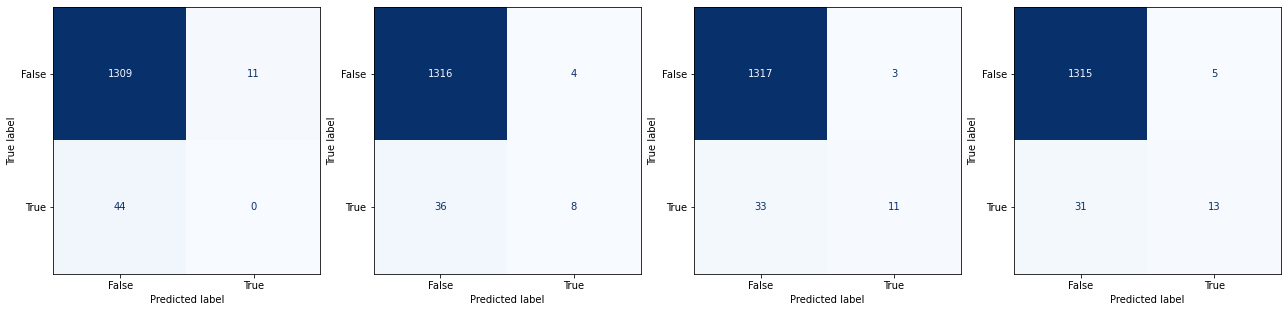

In [38]:
fig, ax =plt.subplots(1,4,figsize=(22,5))

ConfusionMatrixDisplay.from_predictions(y_test,pred_y_lr,
                                       colorbar=False, ax=ax[0],cmap=plt.cm.Blues,
                                       display_labels=['False','True'])

ConfusionMatrixDisplay.from_predictions(y_test,pred_y_xg,
                                       colorbar=False, ax=ax[1],cmap=plt.cm.Blues,
                                       display_labels=['False','True'])

ConfusionMatrixDisplay.from_predictions(y_test,pred_y_rf,
                                       colorbar=False, ax=ax[2],cmap=plt.cm.Blues,
                                       display_labels=['False','True'])

ConfusionMatrixDisplay.from_predictions(y_test,pred_y_lgbm,
                                       colorbar=False, ax=ax[3],cmap=plt.cm.Blues,
                                       display_labels=['False','True'])

# Bayesian Optimization

In [59]:
cat_features = data_csv.select_dtypes(['object']).columns.to_list()

In [60]:
data_csv.dtypes.value_counts()

float64    93
int64       2
dtype: int64

In [61]:
XY_train_lgb = lgb.Dataset(X_train_all, label=y_train_all, categorical_feature = cat_features, free_raw_data=False)
XY_test_lgb = lgb.Dataset(X_test, label=y_test, categorical_feature = cat_features, free_raw_data=False)

In [73]:
def search_best_param(X,y):
  XY_train = lgb.Dataset(data=X,label=y, free_raw_data =False)

  def lightGBM_CV(max_depth, num_leaves, n_estimators, learning_rate, subsample, colsample_bytree, lambda_l1, lambda_l2, min_child_weight):
    params = {'boosting_type': 'gbdt', 'objective':'binary','metric':'auc','verbose':-1,'early_stopping_round':100}
    params['max_depth'] = int(round(max_depth))
    params['num_leaves'] = int(round(num_leaves))
    params['n_estimators'] = int(round(n_estimators))
    params['learning_rate'] = learning_rate
    params['subsample'] = subsample
    params['colsample_bytree']=colsample_bytree
    params['lambda_l1'] = max(lambda_l1,0)
    params['lambda_l2'] = max(lambda_l2,0)
    params['min_child_weight'] = min_child_weight

    score = lgb.cv(params, XY_train, nfold= 5, seed=1, stratified =True, verbose_eval=False, metrics=['auc'])
    return np.mean(score['auc-mean'])

  lightGBM_Bo = BayesianOptimization(lightGBM_CV,
                                     {'max_depth': (5, 50), 'num_leaves': (20, 100), 'n_estimators': (50, 500),
                                      'learning_rate' : (0.01,0.3), 'subsample': (0.7, 0.8), 'colsample_bytree': (0.5,0.99),
                                      'lambda_l1': (0,5), 'lambda_l2': (0,3), 'min_child_weight': (2,50)}, random_state=1, verbose=3)
  #np.random.seed(1)
  lightGBM_Bo.maximize(init_points=5,n_iter=5)
  params_set = lightGBM_Bo.max['params']

  max_target = -np.inf

  for i in lightGBM_Bo.res:
    if i['target'] > max_target:
      params_set = i['params']
      max_target = i['target']
  params_set.update({'verbose':-1})
  params_set.update({'metric':'auc'})
  params_set.update({'boosting_type':'gbdt'})
  params_set.update({'objective':'binary'})

  params_set['max_depth'] = int(round(params_set['max_depth']))
  params_set['num_leaves'] = int(round(params_set['num_leaves']))
  params_set['n_estimators'] = int(round(params_set['n_estimators']))
  params_set['seed'] = 1

  return params_set

In [74]:
best_params = search_best_param(X_train_all,y_train_all)

|   iter    |  target   | colsam... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.9417    | 0.7043    | 3.602     | 0.0003431 | 0.09768   | 11.6      | 6.432     | 133.8     | 47.64     | 0.7397    |
| 2         | 0.9394    | 0.764     | 2.096     | 2.056     | 0.06929   | 44.52     | 3.315     | 351.7     | 53.38     | 0.7559    |
| 3         | 0.9374    | 0.5688    | 0.9905    | 2.402     | 0.2908    | 19.1      | 35.23     | 444.4     | 91.57     | 0.7085    |
| 4         | 0.9316    | 0.5191    | 0.8492    | 2.634     | 0.03852   | 23.95     | 47.98     | 289.9     | 75.35     | 0.7316    |
| 5         | 0.9365    | 0.8364    | 4.173     | 0.05486   | 0.2275    | 49.5      | 37.91     | 176.2     | 83.14     | 0.7103    |
| 6         | 0.9352    | 0.6843    | 3.497     | 0.9324    | 

In [75]:
for key, value in best_params.items():
  print(key, ' : ',value)

colsample_bytree  :  0.7043407823042612
lambda_l1  :  3.6016224672107904
lambda_l2  :  0.0003431244520346599
learning_rate  :  0.09767644606323352
max_depth  :  12
min_child_weight  :  6.432252548902294
n_estimators  :  134
num_leaves  :  48
subsample  :  0.739676747423067
verbose  :  -1
metric  :  auc
boosting_type  :  gbdt
objective  :  binary
seed  :  1


# Tuning LightGBM
- Bayesian Optimization으로 Tuning시킨 Parameter들로 LGBM 모델을 Tuning 한다.

In [76]:
lgbm_best = lgb.train(best_params, XY_train_lgb, num_boost_round=100, valid_sets = XY_test_lgb)
# num_boost_round?


[1]	valid_0's auc: 0.92741
[2]	valid_0's auc: 0.931801
[3]	valid_0's auc: 0.92766
[4]	valid_0's auc: 0.926438
[5]	valid_0's auc: 0.925964
[6]	valid_0's auc: 0.93218
[7]	valid_0's auc: 0.932378
[8]	valid_0's auc: 0.93447
[9]	valid_0's auc: 0.938473
[10]	valid_0's auc: 0.937672
[11]	valid_0's auc: 0.941632
[12]	valid_0's auc: 0.941804
[13]	valid_0's auc: 0.942734
[14]	valid_0's auc: 0.944198
[15]	valid_0's auc: 0.943974
[16]	valid_0's auc: 0.944663
[17]	valid_0's auc: 0.946402
[18]	valid_0's auc: 0.947503
[19]	valid_0's auc: 0.948192
[20]	valid_0's auc: 0.949122
[21]	valid_0's auc: 0.948933
[22]	valid_0's auc: 0.948691
[23]	valid_0's auc: 0.949001
[24]	valid_0's auc: 0.948881
[25]	valid_0's auc: 0.949518
[26]	valid_0's auc: 0.950603
[27]	valid_0's auc: 0.950913
[28]	valid_0's auc: 0.952135
[29]	valid_0's auc: 0.952342
[30]	valid_0's auc: 0.952686
[31]	valid_0's auc: 0.952961
[32]	valid_0's auc: 0.953065
[33]	valid_0's auc: 0.952738
[34]	valid_0's auc: 0.953254
[35]	valid_0's auc: 0.95349

# Feature Importance

## Importance by LGBM

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

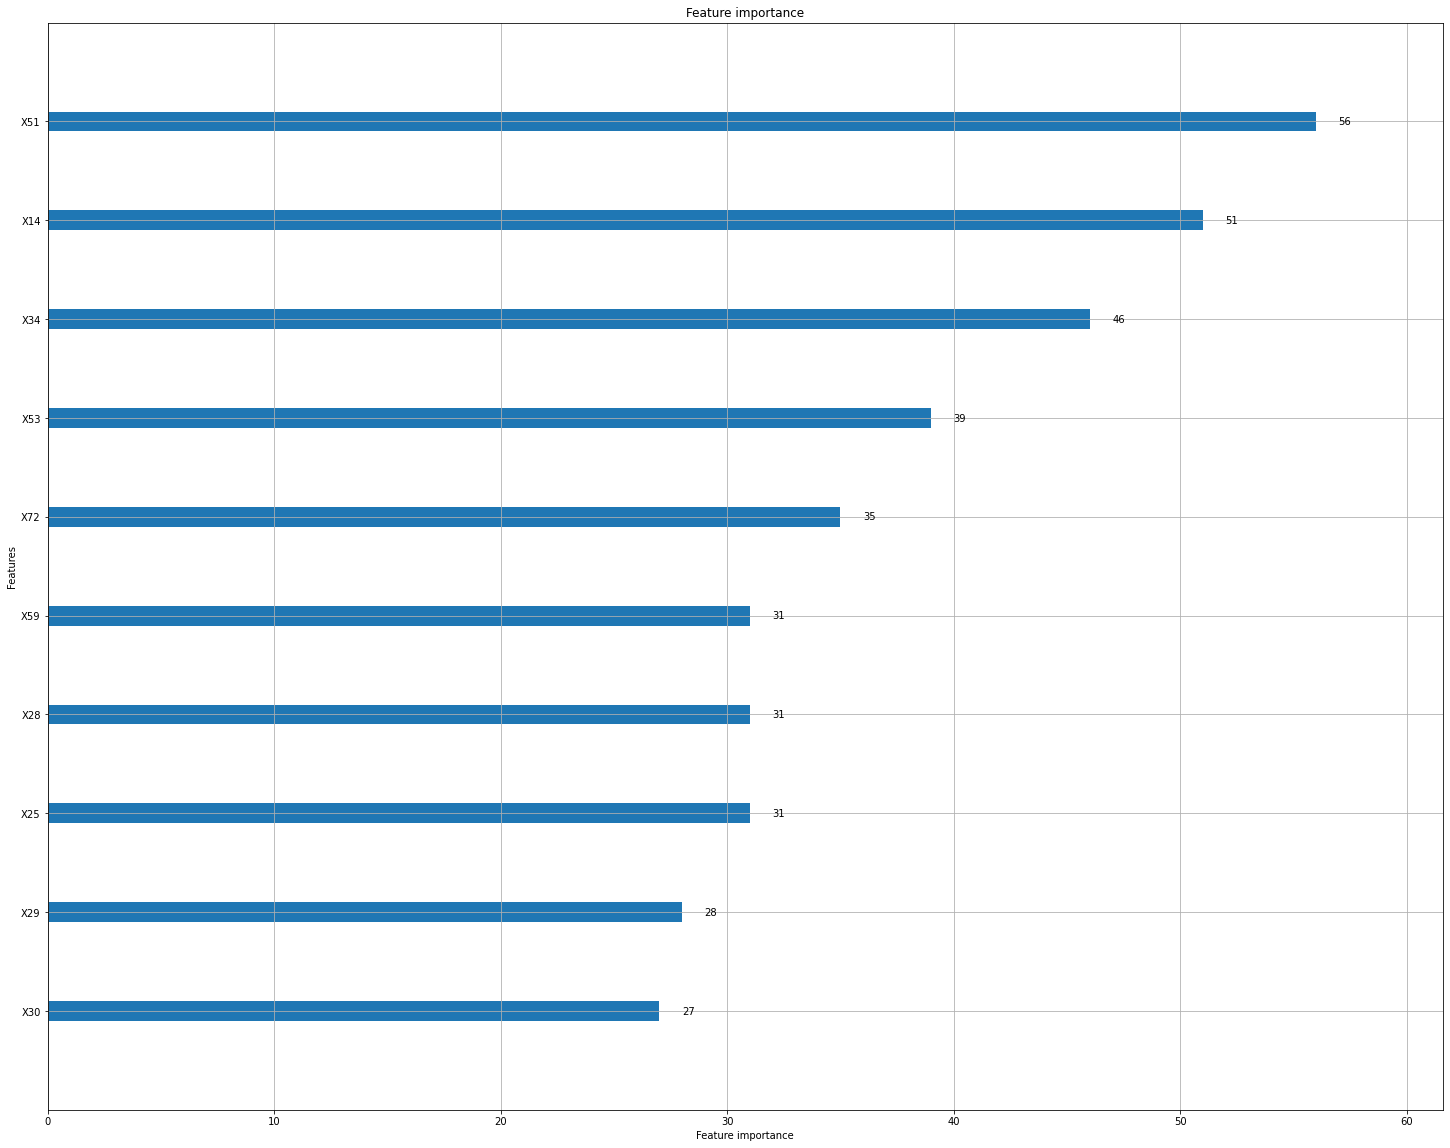

In [77]:
lgb.plot_importance(lgbm_best, figsize=(25,20),max_num_features= 10)

## Importance by Shap Package

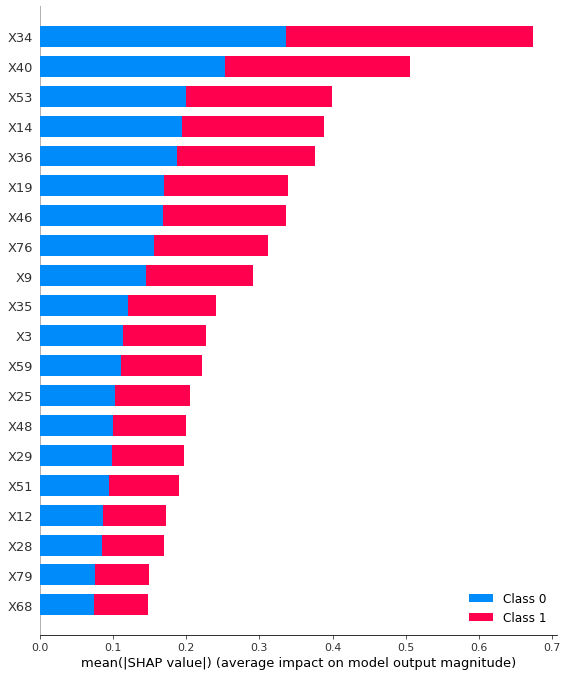

In [78]:
shap_values = shap.TreeExplainer(lgbm_best).shap_values(X_test)
shap.summary_plot(shap_values, X_test)

# LightGBM Model Performance

## ROC Curve

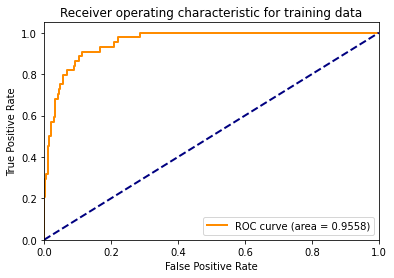

In [82]:
#from IPython.core.interactiveshell import removed_co_newlocals
y_probas = lgbm_best.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_probas)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color = 'darkorange',lw=lw,label='ROC curve (area = %0.4f)' %roc_auc)
plt.plot([0,1],[0, 1],color='navy',lw=lw,linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for training data')
plt.legend(loc= 'lower right')
plt.show()

Best Threshold=0.025182, G-Mean = 0.898


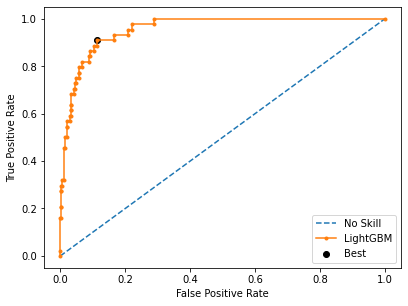

In [86]:
y_pred = lgbm_best.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
gmeans = np.sqrt(tpr*(1-fpr))

ix = np.argmax(gmeans)
print("Best Threshold=%f, G-Mean = %.3f" % (threshold[ix], gmeans[ix]))

plt.figure(num=0,figsize=[6.4,4.8])
plt.plot([0,1],[0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LightGBM')
plt.scatter(fpr[ix],tpr[ix],marker='o',color='black',label='Best')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1320
           1       0.21      0.91      0.34        44

    accuracy                           0.89      1364
   macro avg       0.60      0.90      0.64      1364
weighted avg       0.97      0.89      0.92      1364

Accuracy: 88.78%
Recall: 90.91%


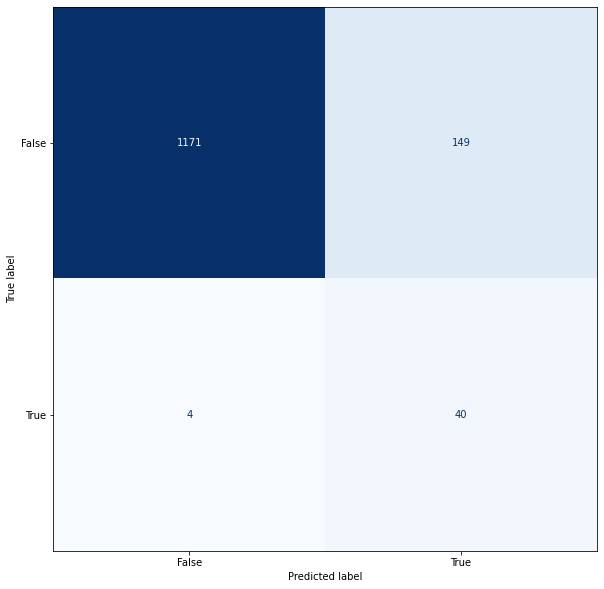

In [90]:
pref_y_bin = binarizeArray(y_pred,threshold[ix])
cm = confusion_matrix(y_test, pref_y_bin)
#plot_confusion_matrix_custom(cm=cm,normalize=False, target_names = ['0','1'], title="Confusion Matrix")

fig, ax =plt.subplots(1,1,figsize=(10,10))

ConfusionMatrixDisplay.from_predictions(y_test,pref_y_bin,
                                       colorbar=False, ax=ax,cmap=plt.cm.Blues,
                                       display_labels=['False','True'])
print(classification_report(y_test,pref_y_bin))
print("Accuracy: %.2f%%" % (accuracy_score(y_test,pref_y_bin)*100.0))
print("Recall: %.2f%%" % (recall_score(y_test,pref_y_bin)*100.0))